In [1]:
import os
os.chdir('..')
from notebooks import config
import torch
import numpy as np
import scipy.ndimage
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow,imsShow
from utils.imgPatch import imgPatch
import matplotlib.pyplot as plt
from model.seg_model.deeplabv3_plus import deeplabv3plus, deeplabv3plus_imp
from model.seg_model.model_scales_in import unet_scales
from model.seg_model.model_scales_gate import unet_scales_gate
from utils.preprocess import normalize
import random 


In [12]:
# sen1 images
scene_num = 'scene19'
path_s1_ascend = config.dir_as + '/' + scene_num+ '_s1_ascend.tif'
path_s1_descend = config.dir_des + '/' + scene_num+ '_s1_descend.tif'
path_s1_truth = config.dir_truth + '/'+ scene_num + '_wat_truth.tif'
s1_ascend, s1_ascend_info = readTiff(path_in=path_s1_ascend)
s1_descend, s1_descend_info = readTiff(path_in=path_s1_descend)
s1_img = np.concatenate((s1_ascend, s1_descend), axis=2)
s1_truth, s1_truth_info = readTiff(path_in=path_s1_truth)
print(s1_img.shape)


(3076, 3373, 4)


### Show the s1 image and the water truth

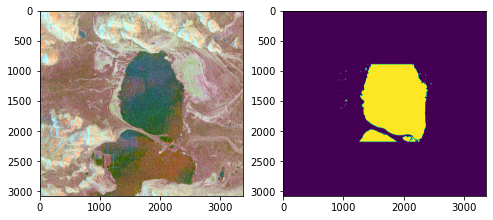

In [13]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
imgShow(s1_img, color_bands=(2,1,0), clip_percent=2, per_band_clip='True')
plt.subplot(1,2,2)
imgShow(s1_truth)


In [14]:
'''Model loading'''
model_name= 'model_scales_gate_001'
model_weights = config.root + '/model/pretrained/'+ model_name +'_weights.pth'
# model = unet_scales(num_bands=4, num_classes=2, \
#                         scale_high=2048, scale_mid=512, scale_low=256)
model = unet_scales_gate(num_bands=4, num_classes=2, \
                        scale_high=2048, scale_mid=512, scale_low=256)
model.load_state_dict(torch.load(model_weights))
model=model.eval()



In [15]:
'''image normalization'''
s1_img_nor = s1_img.copy()
for i in range(s1_img.shape[-1]):
    s1_img_nor[:,:,i] = (s1_img[:,:,i] - config.s1_min[i])/(config.s1_max[i]-config.s1_min[i]+0.0001)


### Convert remote sensing image to multi-scale patches

In [16]:
'''Obtain multi-scale patches'''
imgPat_ins = imgPatch(img=s1_img_nor, patch_size=256, edge_overlay = 60)
patch_list, start_list, img_patch_row, img_patch_col = imgPat_ins.toPatch()
patch_list_mid = imgPat_ins.higher_patch_crop(higher_patch_size=512, start_list=start_list)
patch_list_high = imgPat_ins.higher_patch_crop(higher_patch_size=2048, start_list=start_list)
'''Resize multi-scale patches to the same size'''
patch_list_mid2low = [scipy.ndimage.zoom(input=patch, zoom=(1/2, 1/2, 1), order=0) for patch in patch_list_mid]
patch_list_high2low = [scipy.ndimage.zoom(input=patch, zoom=(1/8, 1/8, 1), order=0) for patch in patch_list_high]
## print
print(patch_list_high[0].shape, patch_list_mid[0].shape, patch_list[0].shape)
print(len(patch_list),len(patch_list_mid),len(patch_list_high))


(2048, 2048, 4) (512, 512, 4) (256, 256, 4)
288 288 288


### Check the multi-scale patches

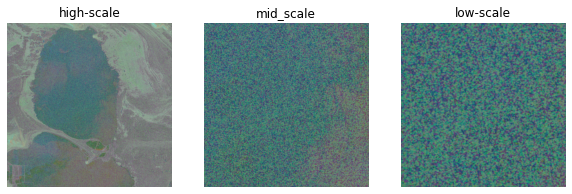

In [17]:
ind =random.randrange(len(patch_list))
plt.figure(figsize=(10,4))
patch_list_sel = [patch_list_high[ind],patch_list_mid[ind],patch_list[ind]]
patch_name = ['high-scale','mid_scale','low-scale']
imsShow(img_list=patch_list_sel, img_name_list=patch_name)


### Surface water mapping based on sentinel-1 image and pretrained deep learning model

In [18]:
pred_patch_list = []

'''----formating data: from 3d to 4d torch.tensor----'''
patch_list_high2low_2 = [torch.from_numpy(patch.transpose(2,0,1)[np.newaxis, :]).float() for patch in patch_list_high2low]
patch_list_mid2low_2 = [torch.from_numpy(patch.transpose(2,0,1)[np.newaxis, :]).float() for patch in patch_list_mid2low]
patch_list_2 = [torch.from_numpy(patch.transpose(2,0,1)[np.newaxis, :]).float() for patch in patch_list]

'''----Obtain the prediction patches----'''
for ind in range(len(patch_list)):
    input = (patch_list_high2low_2[ind], patch_list_mid2low_2[ind], patch_list_2[ind])
    with torch.no_grad():
        # pred_patch = model(input[2])  ### for single-scale patch
        pred_patch = model(input)  ### for multi-scale patch
        if isinstance(pred_patch,tuple):
            pred_patch = pred_patch[0]
    pred_patch_list.append(pred_patch)

'''----Convert the patches to image----'''
pred_patch_list = [np.squeeze(patch, axis = 0).permute(1, 2, 0) for patch in pred_patch_list]
pro_map = imgPat_ins.toImage(pred_patch_list, img_patch_row, img_patch_col)
cla_map = np.where(pro_map>0.5, 1, 0)


### Visualize the final classification map

(3076, 3373, 4)
(3076, 3373, 1)


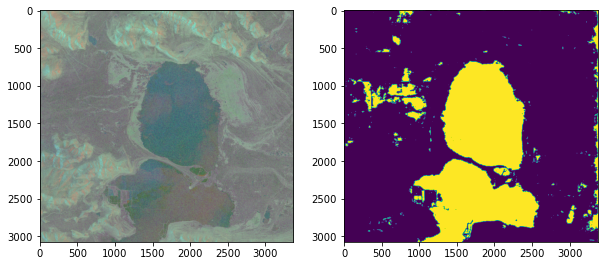

In [19]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
imgShow(s1_img_nor, clip_percent=0, color_bands=(2,1,0))
plt.subplot(1,2,2)
plt.imshow(cla_map)
print(s1_img_nor.shape)
print(cla_map.shape)
